In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


In [14]:
econ_sentiment_data = 'data/economic_sentiment_dataset.csv'
fin_stab_data = 'data/financial_stability_dataset.csv'
full_mac_data = 'data/full_macro_data.csv'
merged_dataset = 'data/merged_dataset.csv'

df1 = pd.read_csv(econ_sentiment_data)
df2 = pd.read_csv(fin_stab_data)
df3 = pd.read_csv(full_mac_data)
df4 = pd.read_csv(merged_dataset)

In [5]:
df = df1.merge(df2, on='DATE').merge(df3, on='DATE')
df['DATE'] = pd.to_datetime(df['DATE'])

# Extract year, month, and day as separate features
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Day'] = df['DATE'].dt.day

#Drop date column
df.drop(columns=['DATE'], inplace=True)

df.head

<bound method NDFrame.head of       Inflation_Rate_x  USD_Index_x  Recession_x     ffer_x      tcs_x  \
0               21.480       108.77          0.0  19.084516   458080.0   
1               21.480       108.77          0.0  19.084516   458080.0   
2               21.620       108.77          0.0  19.084516   458080.0   
3               21.620       108.77          0.0  19.084516   458080.0   
4               22.000       108.77          0.0  19.084516   458080.0   
...                ...          ...          ...        ...        ...   
7088           302.918       110.12          0.0   0.079032  1598020.0   
7089           302.918       110.12          0.0   0.079032  1598020.0   
7090           303.294       110.12          0.0   0.079032  1598020.0   
7091           303.294       110.12          0.0   0.079032  1598020.0   
7092           303.841       110.12          0.0   0.079032  1598020.0   

      Housing_Index_x  unrate_x  GDP_x  unrate_y   psr  ...     20 Yr  \
0       

In [14]:
#Setting up features and labels
target = 'ir'
feats = df.drop(columns=[target,'20 Yr', '30 Yr', '10 Yr', '7 Yr', '5 Yr', '3 Yr', '2 Yr', '1 Yr']).values
labels = df[target].values.reshape(-1, 1)

X_tensor = torch.tensor(feats, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.float32)

def create_sequences(X, y, window_size):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - window_size):
        sequences_X.append(X[i : i + window_size])  # Take `window_size` past steps
        sequences_y.append(y[i + window_size])  # Target is the next step after the window
    return torch.stack(sequences_X), torch.stack(sequences_y)

window_size = 10
X_tensor, y_tensor = create_sequences(X_tensor, y_tensor, window_size)

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [8]:
# Define LSTM neural network
class InterestRateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=512, num_layers=3):
        super(InterestRateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.activation(self.fc(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = x[:, -1, :]  # Take the last time step's output
        return x

# Initialize model
input_size = X_tensor.shape[2]  # Number of features
model = InterestRateLSTM(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def compute_metrics(loader, model, criterion):
    total_loss, total_mae, total_rmse = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            mae = torch.mean(torch.abs(outputs - batch_y)).item()
            rmse = torch.sqrt(torch.mean((outputs - batch_y) ** 2)).item()

            total_loss += loss.item()
            total_mae += mae
            total_rmse += rmse

    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_rmse = total_rmse / len(loader)
    return avg_loss, avg_mae, avg_rmse

# Training loop with accuracy metrics
epochs = 50
for epoch in range(epochs):
    model.train()
    total_train_loss, total_train_mae, total_train_rmse = 0, 0, 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        total_train_rmse += torch.sqrt(torch.mean((outputs - batch_y) ** 2)).item()

    # Compute average training loss & metrics
    train_loss = total_train_loss / len(train_loader)
    train_mae = total_train_mae / len(train_loader)
    train_rmse = total_train_rmse / len(train_loader)

    # Compute validation loss & metrics
    val_loss, val_mae, val_rmse = compute_metrics(val_loader, model, criterion)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.6f}, MAE: {train_mae:.6f}, RMSE: {train_rmse:.6f} | "
          f"Val Loss: {val_loss:.6f}, MAE: {val_mae:.6f}, RMSE: {val_rmse:.6f}")

# Evaluate on test set
test_loss, test_mae, test_rmse = compute_metrics(test_loader, model, criterion)
print(f"\nFinal Test Results - Loss: {test_loss:.6f}, MAE: {test_mae:.6f}, RMSE: {test_rmse:.6f}")

Epoch 1/50 | Train Loss: 13.246829, MAE: 2.613493, RMSE: 3.592878 | Val Loss: 10.260215, MAE: 2.451422, RMSE: 3.173935
Epoch 2/50 | Train Loss: 12.112119, MAE: 2.515969, RMSE: 3.457817 | Val Loss: 10.148465, MAE: 2.404949, RMSE: 3.154679
Epoch 3/50 | Train Loss: 12.110463, MAE: 2.504892, RMSE: 3.460677 | Val Loss: 9.751779, MAE: 2.197726, RMSE: 3.080707
Epoch 4/50 | Train Loss: 12.097086, MAE: 2.498683, RMSE: 3.453108 | Val Loss: 10.300324, MAE: 2.467283, RMSE: 3.180766
Epoch 5/50 | Train Loss: 12.153616, MAE: 2.501361, RMSE: 3.465253 | Val Loss: 9.794287, MAE: 2.230295, RMSE: 3.089753
Epoch 6/50 | Train Loss: 12.092530, MAE: 2.516282, RMSE: 3.451529 | Val Loss: 9.724309, MAE: 2.141055, RMSE: 3.072239
Epoch 7/50 | Train Loss: 12.222353, MAE: 2.517036, RMSE: 3.475048 | Val Loss: 9.809786, MAE: 2.239620, RMSE: 3.092869
Epoch 8/50 | Train Loss: 12.150662, MAE: 2.513384, RMSE: 3.465092 | Val Loss: 9.765359, MAE: 2.209810, RMSE: 3.083713
Epoch 9/50 | Train Loss: 12.095018, MAE: 2.501104, RM

In [15]:
df4['DATE'] = pd.to_datetime(df4['DATE'])

# Extract year, month, and day as separate features
df4['Year'] = df4['DATE'].dt.year
df4['Month'] = df4['DATE'].dt.month
df4['Day'] = df4['DATE'].dt.day

#Drop date column
df4.drop(columns=['DATE'], inplace=True)
df4.drop(df4.index[0:649])
#df4.head
df4.drop(columns=['Date','date', 'Change %'], inplace=True)
df4['change_percent'] = (df4['ir'] - df4['ir'].shift(1))/df4['ir'].shift(1)
df4['change_percent'] = df4['change_percent'].fillna(0)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
robust_df = df4.copy()
robust_df.iloc[:, :-1] = scaler.fit_transform(df4.iloc[:, :-1])  
robust_df.head



C:\Users\mikha\AppData\Local\Temp\ipykernel_2668\2565796780.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-5.25       -5.25       -5.25       ...  1.08333333  1.08333333
  1.08333333]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  robust_df.iloc[:, :-1] = scaler.fit_transform(df4.iloc[:, :-1])
C:\Users\mikha\AppData\Local\Temp\ipykernel_2668\2565796780.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.86956522 -0.69565217 -0.52173913 ... -0.34782609 -0.17391304
  0.        ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  robust_df.iloc[:, :-1] = scaler.fit_transform(df4.iloc[:, :-1])
C:\Users\mikha\AppData\Local\Temp\ipykernel_2668\2565796780.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future err

<bound method NDFrame.head of       REAINTRATREARAT10Y       GDP    unrate       psr        m2     dspic  \
0               4.466311 -2.302642  0.642857  1.782609 -1.047034 -2.372362   
1               4.466311 -2.302642  0.642857  1.782609 -1.047034 -2.372362   
2               4.466311 -2.302642  0.642857  1.782609 -1.047034 -2.372362   
3               4.466311 -2.302208  0.642857  1.782609 -1.047034 -2.372362   
4               4.466311 -2.302208  0.642857  1.782609 -1.047034 -2.372362   
...                  ...       ...       ...       ...       ...       ...   
6357            0.258367  1.750231 -0.392857  0.217391  1.860899  1.182709   
6358            0.692103  1.750231 -0.392857  0.217391  1.860899  1.182709   
6359            0.271672  1.750231 -0.392857  0.217391  1.860899  1.182709   
6360            0.271672  1.750231 -0.392857  0.217391  1.860899  1.182709   
6361            0.271672  1.750231 -0.392857  0.217391  1.860899  1.182709   

           pce      reer       ir

In [28]:
#Setting up features and labels
target = 'ir'
feats = robust_df.drop(columns=[target]).values #,'Date','date', 'Change %']).values
labels = robust_df[target].values.reshape(-1, 1)

X_tensor = torch.tensor(feats, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.float32)

def create_sequences(X, y, window_size):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - window_size):
        sequences_X.append(X[i : i + window_size])  # Take `window_size` past steps
        sequences_y.append(y[i + window_size])  # Target is the next step after the window
    return torch.stack(sequences_X), torch.stack(sequences_y)

window_size = 30
X_tensor, y_tensor = create_sequences(X_tensor, y_tensor, window_size)

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [33]:
# Define LSTM neural network
class InterestRateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=272, num_layers=5):
        super(InterestRateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        #self.fc2 = nn.Linear(64, 1)
        #self.fc3 = nn.Linear(64, 1)
        #self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.batch_norm(x[:, -1, :])
        x = self.fc(x)
        #x = self.activation(self.fc2(x))
        #x = self.activation(self.fc3(x))
          # Take the last time step's output
        return x

# Initialize model
input_size = X_tensor.shape[2]  # Number of features
model = InterestRateLSTM(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
def compute_metrics(loader, model, criterion):
    total_loss, total_mae, total_rmse = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            mae = torch.mean(torch.abs(outputs - batch_y)).item()
            rmse = torch.sqrt(torch.mean((outputs - batch_y) ** 2)).item()

            total_loss += loss.item()
            total_mae += mae
            total_rmse += rmse

    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_rmse = total_rmse / len(loader)
    return avg_loss, avg_mae, avg_rmse

# Training loop with Early Stopping
epochs = 50
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_train_loss, total_train_mae, total_train_rmse = 0, 0, 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        total_train_rmse += torch.sqrt(torch.mean((outputs - batch_y) ** 2)).item()

    # Compute average training loss & metrics
    train_loss = total_train_loss / len(train_loader)
    train_mae = total_train_mae / len(train_loader)
    train_rmse = total_train_rmse / len(train_loader)

    # Compute validation loss & metrics
    val_loss, val_mae, val_rmse = compute_metrics(val_loader, model, criterion)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.6f}, MAE: {train_mae:.6f}, RMSE: {train_rmse:.6f} | "
          f"Val Loss: {val_loss:.6f}, MAE: {val_mae:.6f}, RMSE: {val_rmse:.6f}")

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter if validation improves
        best_model_state = model.state_dict()  # Save best model
    else:
        early_stop_counter += 1  # Increase counter if no improvement

    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}. Stopping training.")
        break

# Load the best model before evaluating on the test set
model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_mae, test_rmse = compute_metrics(test_loader, model, criterion)
print(f"\nFinal Test Results - Loss: {test_loss:.6f}, MAE: {test_mae:.6f}, RMSE: {test_rmse:.6f}")
torch.save(model.state_dict(), "model_weights.pth")

Epoch 1/50 | Train Loss: 0.514537, MAE: 0.488228, RMSE: 0.662036 | Val Loss: 1.487724, MAE: 0.753887, RMSE: 1.216644
Epoch 2/50 | Train Loss: 0.113703, MAE: 0.266346, RMSE: 0.333159 | Val Loss: 1.423593, MAE: 0.751602, RMSE: 1.190246
Epoch 3/50 | Train Loss: 0.092664, MAE: 0.224634, RMSE: 0.297999 | Val Loss: 1.382842, MAE: 0.755424, RMSE: 1.173226
Epoch 4/50 | Train Loss: 0.061700, MAE: 0.174980, RMSE: 0.242909 | Val Loss: 1.266107, MAE: 0.729370, RMSE: 1.122674
Epoch 5/50 | Train Loss: 0.036981, MAE: 0.136767, RMSE: 0.189821 | Val Loss: 1.124040, MAE: 0.692111, RMSE: 1.057855
Epoch 6/50 | Train Loss: 0.043440, MAE: 0.141239, RMSE: 0.204522 | Val Loss: 0.975962, MAE: 0.653028, RMSE: 0.985761
Epoch 7/50 | Train Loss: 0.030077, MAE: 0.123799, RMSE: 0.172315 | Val Loss: 0.697831, MAE: 0.558004, RMSE: 0.833594
Epoch 8/50 | Train Loss: 0.035017, MAE: 0.128211, RMSE: 0.183455 | Val Loss: 0.477329, MAE: 0.484612, RMSE: 0.689616
Epoch 9/50 | Train Loss: 0.040837, MAE: 0.133630, RMSE: 0.196461

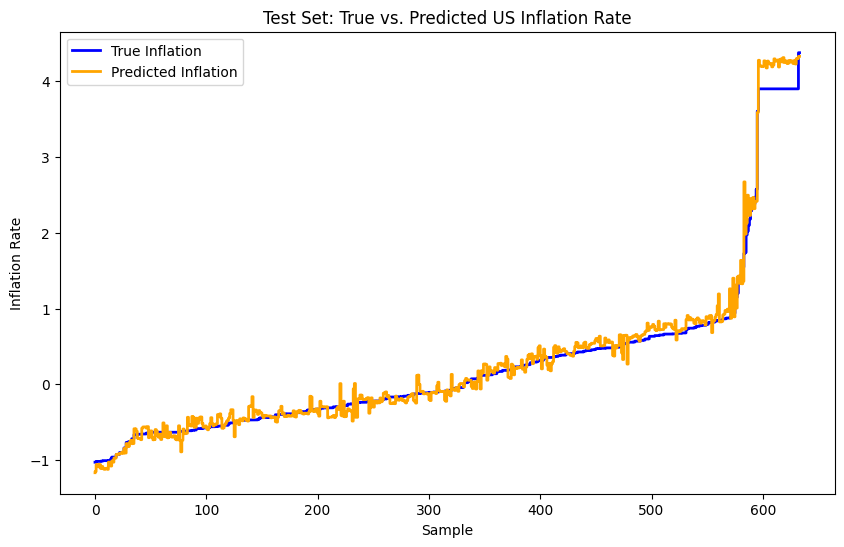

In [35]:
import matplotlib.pyplot as plt

# Get predictions and actual values from test set
model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get model predictions
        actuals.extend(batch_y.numpy().flatten())  # Convert tensor to 1D array
        predictions.extend(outputs.numpy().flatten())  # Convert tensor to 1D array

# Convert lists to NumPy arrays
actuals = np.array(actuals)
predictions = np.array(predictions)

# Sort by actual values (if needed) to get a structured graph
sorted_indices = np.argsort(actuals)
actuals = actuals[sorted_indices]
predictions = predictions[sorted_indices]

# Plot actual vs predicted values with step-like lines
plt.figure(figsize=(10, 6))
plt.step(range(len(actuals)), actuals, label="True Inflation", color="blue", linewidth=2)
plt.step(range(len(predictions)), predictions, label="Predicted Inflation", color="orange", linewidth=2)

plt.xlabel("Sample")
plt.ylabel("Inflation Rate")
plt.title("Test Set: True vs. Predicted US Inflation Rate")
plt.legend()
plt.show()